# Quantum Game Theory

__Notes: 
(1) The answers to the exercises in this notebook do not show up when looking at this notebook on GitHub. In order to see them, please open up this notebook using Jupyter.
(2) Before running the notebook in Jupyter, please clone the github repo and run pip install -e .__

In [7]:
import sys
sys.path.append('../')

# Run this cell once to load all the relevant packages and settings
%load_ext autoreload
%autoreload 2

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from qiskit.extensions import XGate, HGate
from backend.logic import Game
import pandas as pd
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## What you will learn in this tutorial
* __Game Theory__ - What a "game theory" game is.
* __Quantum Game Theory__ - What a "quantum game theory" game is and how you can study these types of games using Qiskit.
* __Classical vs Quantum Games__ - How the way we think about strategies change when you go from the classical to the quantum regime.

## Game Theory
Game Theory is defined as "the study of mathematical models of strategic interaction among rational decision-makers" [1], which is a very formal way of saying "it's the study of how games are played!". Although modern game theory was in fact first constructed using a [formal mathematical framework](https://link.springer.com/article/10.1007/BF01448847), we believe that the best way to get introduced to game theory is to start playing a game, so let's dive straight in!

### The Prisoner's Dilemma
Probably the most famous game theoretical game is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma). There are many variants to this game each with their own story, so here's our story for the game:

Both you and I team up to break into a zoo and steal a panda (just for a little bit, we are of course going to give it back!). Unfortunately we both get caught, but not quite red handed, so it isn't such an open-and-shut case for the police. In order to try and get a confession out of both of us, the police separate us into different rooms and give each of us two options:
* To remain silent and take our chances - we shall call this strategy '0'
* To confess and maybe receive a reduced sentence - we shall call this strategy '1'

So together, there are 4 possible outcomes that could happen: '00' (where we both remain silent), '01' (where you remain silent and I confess), '10' (where you confess and I remain silent) and '11' (where we both confess).
We are told that if we both remain silent (i.e. end up with the '00' outcome), the police still have enough evidence sentence us both to 1 month in prison. However, if one of us confesses (i.e. the outcome is either '01' or '10') the player who chose the '1' strategy goes free and the other player (who chose the strategy '0') receives a 3 month prison sentence. Finally, if we both confess, (i.e. the outcome is '11') then we each get a 2 month prison sentence. These strategies are represented below in a payoff table.

![Prisoner's payoff table](../assets/prisoners_table.png)

Throughout this notebook, we will be using the 'QuantumGameTheory' package. So without further ado, let us create the prisoner's dilemma game object by simply calling it:

In [10]:
prisoner_game = Game(game_name='prisoner', num_players=2, protocol="Classical")

The 'game_name' indicates which game to load and for now we will be using the 'Classical' protocol. Now before we play the game, let's have a look at the possible payoffs:

In [11]:
prisoner_game.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


This shows us the outcomes represented in bits and the payoff for each outcome (this table is the same as the above payoff table). Notice that the payoff representing a 3 month prison sentence is -3 and not 3. This is because players are always trying to maximize their payoff, so the more months in prison will give you more negative results. 

Now let's play! For this game there are two players, P1 and P2; you and me.  To play the game, we can simply input our chosen strategy (0 or 1) into P1_strategy and P2_strategy to see who the winner is.

In [12]:
P1_strategy = 1 # pick your strategy
P2_strategy = 1 # I pick strategy '1'
combined_strategies = [P1_strategy, P2_strategy]
outcomes, results = prisoner_game.play_game(combined_strategies, n_times=1)
prisoner_game.show_results()

,Outcome,Payoffs,Winners,num_times
0,11,"[-2, -2]",No winners,1


__Exercise 1__: What strategy would you choose if you didn't know what strategy I was going to choose? (This can be a bit tricky but it is worth taking the time to think about it before looking at the answer!)

<details>
<summary>Click here for the answer to Exercise 1</summary>
No matter what strategy I choose, the optimal strategy for you is 1 (i.e. to confess). To understand this, let's look at the options starting with my strategies:
<ol>
  <li>First option: I choose strategy 0. If you also choose 0, your payoff is -1 whereas if you choose 1, your payoff is 0. Therefore it is better for you to choose 1 in this case.</li>
  <li>Second option: I choose strategy 1. If you choose 0, your payoff is -3 whereas if you also choose 1, your payoff is -2. Therefore it is also better for you to choose 1 in this case.</li>
</ol>
So it is always better for you to choose 1. By symmetry, this logic works for both of us. Therefore, rationally speaking, we should both always choose option 1. This leads to the concept of the 'dominant strategy' - the strategy that we will choose <i>regardless of what the other person chooses</i> (in this case 1 for the both of us). We say that this game has a 'dominant strategy equilibrium state' with the outcome 11 and payoffs [-2, -2].  
</details>

### Nash Equilibria

In this section, we investigate the most popular type of equilibrium that games can have - the Nash equilibrium. This concept was discovered by the famous mathematician John Nash (portrayed by Russel Crowe in the [Beautiful Mind](https://en.wikipedia.org/wiki/A_Beautiful_Mind_(film)) \). As a complete aside, if you haven't yet seen the [incredible recommendation letter](https://www.reddit.com/r/pics/comments/38nmzm/princeton_university_just_posted_john_nashs/) he received when applying for the Princeton PhD program, I would highly recommend reading it (it's only a few lines)!

Now back to game theory. The best way to understand Nash equilibria is to see them using a game. In particular, we will look at a game called "Bach or Stravinsky" [2]. The game is as follows: Two people (Alya and Bai) want to go out to a concert. Alya prefers Bach and Bai, Stravinksy. However, they both would prefer to go together rather than to either concert alone. Each of them individually has the option of going to the Bach concert - strategy '0' - or going to the Stravinsky concert - strategy '1'. To see the outcomes and the payoffs, let's look at the payoff table.

In [6]:
BoS_game = Game(game_name='BoS', num_players=2, protocol="Classical")
BoS_game.display_payoffs()

Game: BoS
Payoffs: 


,outcome,payoffs
0,00,"(3, 2)"
1,01,"(0, 0)"
2,10,"(0, 0)"
3,11,"(2, 3)"


To start with, we see that there is no dominant strategy equilibrium - neither player has a strategy that will give them the best outcome regardless of the other player's strategy. On the other hand, we know that there are some strategies that are better than others _if a player knows what the other player is going to do_. In this example, say Bai knew that Alya was going to the Bach concert (strategy 0), then he will also choose to go to the Bach concert (because he would rather get a payoff of 2 than 0).

The question now becomes: are there pairs of strategies for which no player would change if the other one was fixed? I.e. is there a combined strategy 'a' and 'b' such that:
1. If Bai knows that Alya chose strategy 'a', then he will choose strategy 'b' _and_ 
2. If Alya knows that Bai chose strategy 'b', then she will choose strategy 'a'?

If this is the case, we say that Alya and Bai are in a Nash equilibrium.

__Exercise 2__: What are the Nash equilibria in the Bach or Stravinsky game?

<details>
<summary>Click here for the answer to Exercise 2</summary>
The two strategies that Alya and Bai can choose that lead to Nash equilibria are '00' or '11'. Let's look at the first one from each of the players' points of view:
<ol>
    <li> If Alya knew that Bai was going to pick 0 (i.e. go to the Bach concert), then she would also pick 0 to maximize her payoff.</li>
    <li> If Bai knew that Alya was going to pick 0, then he would also pick 0 to maximize his payoff.</li>
</ol>
Therefore, neither player will deviate from their strategies. The same applies for the '11' strategy

__Exercise 3__: Are dominant strategy equilibria Nash equilibria? What about vice-versa? (If you're not sure what dominant strategy equilibria are, have a look at the answer to Exercise 1)

<details>
<summary>Click here for the answer to Exercise 3</summary>
    Dominant strategy equilibria are also <i>always</i> Nash equilibria - if the players each choose the dominant strategy, they also will not change their strategies if they know what the other player is going to do, which by definition puts them in a Nash equilibrium. On the other hand, not all Nash equilibria are dominant strategy equilibria as can be seen using the Bach or Stravinsky game above.

### General 2x2 Games

The prisoner's dilemma and Bach or Stravinksy game are known as a "2x2 games" - games in which there are 2 players and they each have the option between 2 strategies. So immediately we can see how to make any 2x2 game in principle. Just fill out the payoff table below and you have a game you can then play by filling in the P1_choice and P2_choice.

In [16]:
my_game_name = 'custom' # fill in game name
my_payoff_table = {'00': "0,0", 
                   '01': "10,10",
                   '10': "5,20",
                   '11': "5,10"} # fill in payoffs
my_game = Game(my_game_name, num_players=2, protocol="Classical", payoff_table=my_payoff_table)
my_game.display_payoffs()

Game: custom
Payoffs: 


,outcome,payoffs
0,00,"(0, 0)"
1,01,"(10, 10)"
2,10,"(5, 20)"
3,11,"(5, 10)"


In [19]:
P1_choice = 0 # fill in here
P2_choice = 0 # fill in here
choices = [P1_choice, P2_choice]
outcomes, results = my_game.play_game(choices, n_times=1)
my_game.show_results()

,Outcome,Payoffs,Winners,num_times
0,00,"[0, 0]",No winners,1


Here ends our basic introduction to Game Theory. There are [many](https://www.youtube.com/watch?v=3Y1WpytiHKE), [many](http://web.mit.edu/rgibbons/www/Gibbons_An%20Introduction%20to%20Applicable%20Game%20Theory.pdf) [good](http://www.rasmusen.org/GI/download.htm) [resources](https://econweb.ucsd.edu/~jsobel/200Cs09/Kartik_Notes.pdf) out there to learn more about classical game theory. As far as this tutorial is concerned, we will end our discussion on classical game theory here. Now let's go quantum!

## Quantum Game Theory

Quantum Game Theory is a field that was first introduced by D. Meyer [3] in 1999 but it wasn't until later that year that a formal quantum game theory protocol was invented by Eisert, Wilkens & Lewenstein [4] and hence is called the "EWL quantization protocol". Since then there have been many contributions to the field, for which we refer the reader to a [comprehensive review of the field by Khan et al.](https://link.springer.com/article/10.1007/s11128-018-2082-8) But for now, let us start by looking at the EWL quantization protocol.

### The EWL Quantization Protocol

Just as reminder, here is the protocol for a classical 2x2 game:
1. Initialization - we start with two '0' bits
2. Strategy - each player receives a bit and decides to either keep it as a 0 or flip it to a 1
3. Outcome - the outcome is the combination of the two bits
4. Payoff - the payoff table is used to find the payoff for each player given the outcome

Notice that for all 2x2 games, the choice of strategies and the final payoffs are the only things that depend on the game - the the steps to take and the order to take them remain the same.

When dealing with _quantum_ game theory, we require the EWL quantum protocol to follow two rules: __Rule 1:__ It has to distribute maximally entangled qubits to the players and __Rule 2:__ it has to generalize the classical version of the game. We will first explain the recipe to turn a classical game theory game into a quantum game and then walk through how to implement it in Qiskit. Let's look at how to turn a 2x2 classical game into a quantum game.

__1. Initialization__ - We start with two $|0\rangle$ qubits and two classical bits that we will use to store measurement results. Ignoring the classical bits for now, this gives us $$|00\rangle $$ 
__2. Entanglement__ - We want the qubits to be maximally entangled to each other by an operator before we hand them off to the players. For now we will call this entangling operator $J$ (and explain it further later on). This gives us the state $$J|00\rangle $$
__3. Strategy__ - Each player is then given a qubit and they each apply a single-qubit unitary operator (or 'strategy') of their choice to their qubit (as opposed to the classical version where they can only choose between keeping it or flipping it). Let's call player 1's strategy $U_1$ and player 2's strategy $U_2$. We then end up with $$U_1U_2J|00\rangle $$ 
__4. 'Disentanglement'__- The qubits are then put through a 'disentangling' gate $J^{\dagger}$ (we will get to why later on). We now have $$J^{\dagger}U_1U_2J|00\rangle $$
__5. Measurement__ - The qubits are measured in the computational basis and the measurements are stored in the two classical bits <br>
__6. Outcome__ - The outcome is the combination of the two (classical) bits <br>
__7. Payoff__ - The payoff table is used to find the payoff for each player given the outcome <br>

Similar to the 2x2 classical games, only the strategies taken and payoff tables differ depending on the specific game - the steps to be taken and the order that they are taken in remain same independent of the specific 2x2 game.

#### The Entangling Operator $J$

The entangling and 'disentangling' operators ($J$ and $J^{\dagger}$) are introduced to satisfy the two rules mentioned above. Here is a more detailed description of the rules:

__Rule 1__ : We need to pick an operator that leads to a maximally entangled state before distributing the qubits to each individual player <br>
__Rule 2__ : When playing a quantum game, if both players' strategies are just combinations of either 'keeping it the same' i.e $I$, or 'flipping it' i.e. $X$, then the outcome of the game should be the same as the classical version of the game. This ensures that the classical game is contained within the quantum game.

This leaves us with many possibilities for the $J$ operator. We use the operator chosen by Benjamin & Hayden [5]: $$J = \frac{1}{\sqrt{2}} (I^{\otimes 2} + iX^{\otimes 2})$$ where $I$ is the identity operator and $X$ is the Pauli-X gate. The reason for going with Benjamin & Hayden's choice of the $J$ operator is that it is equivalent to the original one by Eisert, Wilkens and Lewenstein (they both satisfy __Rule 1__ and __Rule 2__) but is also more intuitive and easier to implement. 

Applying this operator to the state $|00\rangle$ results in the state $$\frac{1}{\sqrt{2}}\left(|00\rangle + i|11\rangle\right)$$ which is a maximally entangled 2 qubit state.

__Exercise 4__: Show that adding the $J^{\dagger}$ operator at step 4 satisfies __Rule 2__. Hint: start by showing that  $J^{\dagger}$ commutes with $I^{\otimes 2}$ and $X{^\otimes 2}$. 

<details>
<summary>Click here for the answer to Exercise 4</summary>
First we show the commutation relations in the hint. <br>
$\begin{align}
    [J^{\dagger}, I^{\otimes 2}] &= J^{\dagger}I^{\otimes 2} - I^{\otimes 2}J^{\dagger} \\
    &= J^{\dagger} - J^{\dagger} \\
    &= 0 \\
    [J^{\dagger}, X^{\otimes 2}] &= J^{\dagger}X^{\otimes 2} - X^{\otimes 2}J^{\dagger} \\
    &= \frac{1}{\sqrt{2}} (I - iX^{\otimes 2})X^{\otimes 2} - X^{\otimes 2}\frac{1}{\sqrt{2}} (I^{\otimes 2} - iX^{\otimes 2}) \\
    &= \frac{1}{\sqrt{2}} (X^{\otimes 2} - iI^{\otimes 2}) - \frac{1}{\sqrt{2}} (X^{\otimes 2} - iI^{\otimes 2}) \\
    &= 0
\end{align}$

And since $X$ and $I$ commute, this means that $J^{\dagger}$ commutes with any combination of $I$ and $X$ (i.e. $I^{\otimes 2}$, $IX$, $XI$ and $X^{\otimes 2}$).
Now if we look back at step 4 of the protocol $$J^{\dagger}U_1U_2J|00\rangle $$ and impose that $U_1$ and $U_2$ are a combination of $I$ and $X$ gates, we can then move move then interchange the $J^{\dagger}$ operator with the $U_1$ and $U_2$ operators (since they all commute) which gives us $$U_1U_2J^{\dagger}J|00\rangle = U_1U_2|00\rangle.$$ This results in the final state being qubits that have either been 'kept the same' or 'flipped' without any entanglement or superposition states, which is exactly the same as what would happen in the classical version. This is why step for is called 'disentanglement' in quotation marks - the $J^{\dagger}$ gate disentangles the qubits in the case when only the $I$ or $X$ operators are used as strategies.

</details>

### Building a 2x2 Quantum Game

It's finally Qiskit time! In this section, we will be implementing steps 1 to 5 (above). The code has been written in a way that each cell corresponding to the individual steps also includes all the code to of the previous steps such that it can be run on its own.

#### 1. Initialization
Initialize a circuit with two '0' qubits and 2 classical bits that we will use to store measurement results. This gives a starting state $|00\rangle$.

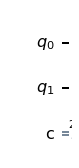

In [9]:
circ = QuantumCircuit(2,2)
circ.draw(output='mpl')

#### 2. Entanglement
We maximally entangle the qubits by inserting the $J$ operator (defined as $J = \frac{1}{\sqrt{2}} (I^{\otimes 2} + iX^{\otimes 2})$) which results in the state $J|00\rangle = \frac{1}{\sqrt{2}}\left(|00\rangle + i|11\rangle\right)$.

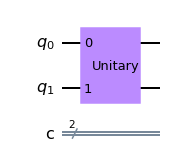

In [10]:
I_2 = np.identity(4)
    
X_2 = np.matrix([[0,0,0,1], 
                   [0,0,1,0],
                   [0,1,0,0],
                   [1,0,0,0]])
J_2 = Operator(1 / np.sqrt(2) * (I_2 + 1j *X_2))    

circ = QuantumCircuit(2,2)
circ.append(J_2, [0,1])
circ.draw(output='mpl')

__Exercise 5__: Calculate the 4x4 matrix for the $J$ operator and show that $J$ is a unitary operator

<details>
<summary>Click here for the answer to Exercise 5</summary>
Computing $J$:
$$I^{\otimes 2} =  \left(\begin{array}{cccc} 1&0&0&0\\
                          0&1&0&0\\
                          0&0&1&0\\
                          0&0&0&1\end{array}\right)$$
$$iX^{\otimes 2} =  \left(\begin{array}{cccc} 0&0&0&i\\
                          0&0&i&0\\
                          0&i&0&0\\
                          i&0&0&0\end{array}\right)$$
Now substituting these in to the equation for the J operator:
$$J = \frac{1}{\sqrt{2}} (I^{\otimes 2} + iX^{\otimes 2}) = \frac{1}{\sqrt{2}}\left(\begin{array}{cccc} 1&0&0&i\\
                                                                                0&1&i&0\\
                                                                                0&i&1&0\\
                                                                                i&0&0&1\end{array}\right)$$

Showing J is unitary:
    
$\begin{align}J^{\dagger}J &= \frac{1}{\sqrt{2}} (I^{\otimes 2} - iX^{\otimes 2}) \frac{1}{\sqrt{2}} (I^{\otimes 2} + iX^{\otimes 2}) \\
&= \frac{1}{2}(I^{\otimes 2} - iX^{\otimes 2} + iX^{\otimes 2} + I^{\otimes 2}) \\
&= I
\end{align}
$
</details>

#### 3. Strategy
Each person can perform a unitary operator on their individual qubit, e.g. player 1 chooses the $X$ and player 2 chooses the $S$ gate (the $S$ gate changes $|1\rangle \rightarrow i|1\rangle$ and does not do anything to $|0\rangle$).

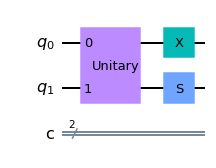

In [11]:
circ = QuantumCircuit(2,2)
circ.append(J_2, [0,1])
circ.x(0) # assigns the X gate to player 1
circ.s(1) # assigns the S gate to player 2
circ.draw(output='mpl')

#### 4. 'Disentanglement'
We now apply the $J^{\dagger}$ gate to satisfy __Rule 2__.

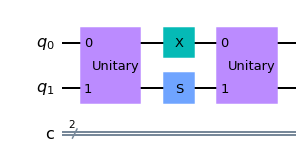

In [12]:
J_2_dg = Operator(1 / np.sqrt(2) * (I_2 - 1j *X_2))

circ = QuantumCircuit(2,2)
circ.append(J_2, [0,1])
circ.x(0) # assigns the X gate to player 1
circ.s(1) # assigns the S gate to player 2
circ.append(J_2_dg, [0,1])
circ.draw(output='mpl')

__Exercise 6__: What is the state of the qubits at this stage of the circuit?

<details>
<summary>Click here for the answer to Exercise 6</summary>
$\begin{align}
J^{\dagger}J &= J^{\dagger}X_1S_2J|00\rangle \\
&= J^{\dagger}X_1S_2\frac{1}{\sqrt{2}}\left(|00\rangle + i|11\rangle\right) \\
&= J^{\dagger}\frac{1}{\sqrt{2}}\left(|10\rangle - |01\rangle\right) \\
&= \frac{1}{\sqrt{2}} (I^{\otimes 2} - iX^{\otimes 2})\frac{1}{\sqrt{2}}\left(|10\rangle - |01\rangle\right) \\
&= \frac{1}{2}\left(|10\rangle - |01\rangle - i|01\rangle + i|10\rangle\right) \\
&= \frac{1+i}{2}(|10\rangle -|01\rangle)
\end{align}$ <br>
So even though player 1 used the $X$ operator to flip their bit, they finally ended in a state that could lead to their final outcome being 0 or 1 with a 50% probability!
</details>

#### 5. 'Measurement'
And we then measure both qubits in the computational basis, saving the answers into the classical registers.

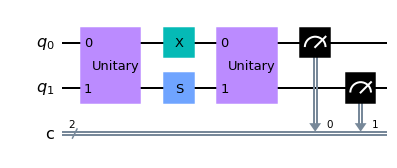

In [13]:
circ = QuantumCircuit(2,2)
circ.append(J_2, [0,1])
circ.x(0) # assigns the X gate to player 1
circ.s(1) # assigns the S gate to player 2
circ.append(J_2_dg, [0,1])
circ.measure([0,1], [0,1])
circ.draw(output='mpl')

Since the last two steps (outcome and payoff) do not involve any quantum processes we are done with building the quantum circuit for a 2x2 quantum game!

### Quantum Prisoner's Dilemma

Now that we have gone through how to write the circuit ourselves, we can use the inbuilt QuantumGameTheory package from now on to simplify the coding going forward, which basically implements the above for you. Let's spin up a quantum version of prisoner's dilemma. 

In [14]:
prisoner_game_quantum = Game(game_name='prisoner', num_players=2, protocol="EWL")
prisoner_game_quantum.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


Notice that the payoff table is identical to the classical version (as expected given the protocol described above). Now let us run the same strategies as above in this game.

Executing circuit ....
Circuit running ...
Circuit finished running, getting counts ...


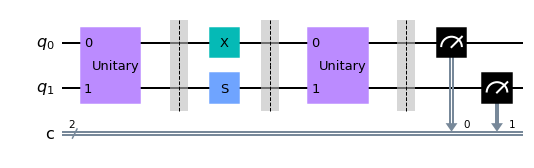

In [15]:
P1_strategy = 'X'
P2_strategy = 'S'
combined_strategies = [P1_strategy, P2_strategy]
outcomes, results = prisoner_game_quantum.play_game(combined_strategies, n_times=1)
prisoner_game_quantum._quantum_game.circ.draw(output='mpl')

In [16]:
prisoner_game_quantum.show_results()

,Outcome,Payoffs,Winners,num_times
0,10,"[0, -3]",Player 1,1


This gives us the outcome of a single game. Let us play the game many times over (say 100) and see the results.

In [17]:
outcomes_sim, results_sim = prisoner_game_quantum.play_game(combined_strategies, n_times = 100)
prisoner_game_quantum.show_results()

Executing circuit ....
Circuit running ...
Circuit finished running, getting counts ...


,Outcome,Payoffs,Winners,num_times
0,10,"[0, -3]",Player 1,50
1,01,"[-3, 0]",Player 2,50


We can now easily visualise the results in the histogram below.

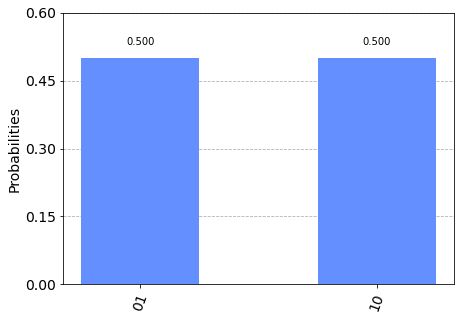

In [18]:
plot_histogram(outcomes_sim)

As you can see, we have about an even split between 01 and 10. Does the outcome make sense? At this point if you haven't done Exercise 6 yet, have a look at the solution to see why the outcome is like this and why, even though player one chose $X$ as their strategy, they still end up with an outcome of '0' half the time!

### Playing on an actual quantum computer

__If you haven't setup your IBMQ account, please click [here](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/fundamentals/1_getting_started_with_qiskit.ipynb) and go to the section titled 'Running circuits from the IBM Q account'.__

So far we have been running everything on the QASM simulator (under the hood). Let's rerun the same game (quantum prisoner's dilemma) with the same strategies (player 1 choose $X$ and player 2 chooses $S$) on a real quantum computer this time! We can do this by simply adding the group and backend of the machine we desire when spinning up the game (this might take a while to run depending on the queue of the machine you select).

In [20]:
from qiskit import IBMQ

IBMQ.save_account('d350e88ee8a1a4438ea6071a22479263dcedc0e60d0eff60fec23b6bc59fa8e6b26d36a9a251479ce2694dbbf69fdf065c612af462e442732c213902efa26a88')
IBMQ.load_account()

prisoner_game_quantum = Game(game_name='prisoner', num_players = 2, protocol="EWL", group='open', backend="real_machine")
P1_strategy = 'X'
P2_strategy = 'S'
combined_strategies = [P1_strategy, P2_strategy]
outcomes_q, results_q = prisoner_game_quantum.play_game(combined_strategies, n_times = 100)
prisoner_game_quantum.show_results()

/home/agustin/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


Loading IBM Q account ... 


ibmqfactory.load_account:WARNING:2021-02-03 12:40:38,072: Credentials are already in use. The existing account in the session will be replaced.


Getting least busy device ...
Least busy device: ibmq_athens
Executing circuit ....
Circuit running ...
Circuit finished running, getting counts ...


,Outcome,Payoffs,Winners,num_times
0,00,"[-1, -1]",No winners,2
1,10,"[0, -3]",Player 1,54
2,01,"[-3, 0]",Player 2,43
3,11,"[-2, -2]",No winners,1


And let's plot the two results (from the QASM simulator and from the actual machine) side-by-side

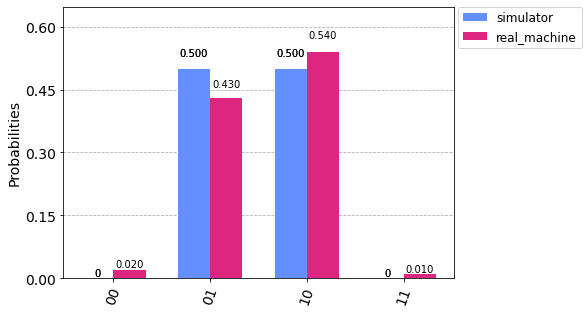

In [21]:
plot_histogram([outcomes_sim,outcomes_q], legend=['simulator', 'real_machine'])

We see that the outcomes '00' and '11' sometimes appear due to the noise of the real machine. Playing around with different systems and/or strategies, one can get a feel for how different machines perform due to their different types and levels of noise.

## Classical vs Quantum Games

So by now you hopefully have a good notion of basic 2x2 classical and quantum games. But what is the real difference between these games? More specifically, if I play the classical game but allow my choices to be randomized, can I reproduce the quantum game? To answer this question, we have to introduce the notion of mixed (i.e. probabilistic) strategies. 

### Mixed Strategies
A mixed strategy is just a strategy which includes classical stochasticity in it, for example "I choose '0' with 50% probability and '1' with 50% probability". This works for quantum strategies too e.g. "I choose 'X' with 33% probability, 'H' with 33% probability and 'S' with 33% probability."  Already we can start to see that classical games (even when allowing for stochasticity) cannot reproduce quantum games (how do we model the effect of stochastic unitary gates with only classical probabilities?). Let's see it in a concrete example: back to our old friend the Prisoner's Dilemma.

### Prisoner's Dilemma Revisited
Let's think of the prisoner's dilemma again but this time using mixed strategies. Let's start by spinning up another prisoner's dilemma game to look at the payoff table.

In [22]:
prisoner_game = Game('prisoner', num_players = 2, protocol="Classical")
prisoner_game.display_payoffs()

Game: prisoner
Payoffs: 


,outcome,payoffs
0,00,"(-1, -1)"
1,01,"(-3, 0)"
2,10,"(0, -3)"
3,11,"(-2, -2)"


You may remember from Exercise 1 that there is a dominant strategy for both players in this game. So mixed strategies are not useful in this case. So how about for the quantum game? Let's just consider pure strategies (i.e. strategies that are not classically stochastic). Is there a dominant strategy there? Naively one could guess that the $X$ strategy is the dominant one, as it corresponds to the classical dominant strategy of choosing '1'. However if a player - say P1 - chooses $X$, then P2 can choose $Z$ which will cause the result to go to their favor 100% of the time: 

In [23]:
prisoner_game.set_protocol("EWL", backend = 'simulator') # we can simply change the protocol of an exisiting game instead of having to spin up a new game every time
P1_strategy = 'X'
P2_strategy = 'Z'
combined_strategies = [P1_strategy, P2_strategy]
outcomes_q, results_q = prisoner_game.play_game(combined_strategies, n_times = 100)
prisoner_game.show_results()

Executing circuit ....
Circuit running ...
Circuit finished running, getting counts ...


,Outcome,Payoffs,Winners,num_times
0,01,"[-3, 0]",Player 2,100


So therefore a quantum version of the game is a very different playing field to the original classical game!

### Nash equilibria in Quantum Games
It turns out that for any 2x2 quantum game in which players only use pure strategies, there is no Nash equilibrium since every strategy always has at least one perfect counter-strategy [6].

__Exercise 7__: We just saw that, for the prisoner's dilemma, a perfect counter-strategy to $X$ is $Z$. What is a perfect counter-strategy to $Z$?

<details>
<summary>Click here for the answer to Exercise 7</summary>
If we say that P1 uses $Z$ and P2 is trying to find the perfect counter-strategy $U_c$, we define without loss of generality
    
$\begin{align}
U_c =  \left(\begin{array}{cc} \cos\left(\frac{\theta}{2}\right)&-e^{i\lambda}\sin\left(\frac{\theta}{2}\right)\\
                          e^{i\phi}\sin\left(\frac{\theta}{2}\right)&e^{i\phi+i\lambda}\cos\left(\frac{\theta}{2}\right)\end{array}\right)
\end{align}$ <br>
    
So now we have
    
$\begin{align}
J^{\dagger}J &= J^{\dagger}Z_1U_cJ|00\rangle \\
&= J^{\dagger}Z_1U_c\frac{1}{\sqrt{2}}\left(|00\rangle + i|11\rangle\right) \\
&= J^{\dagger}U_c\frac{1}{\sqrt{2}}\left(|00\rangle - i|11\rangle\right) \\
&= J^{\dagger}\frac{1}{\sqrt{2}}\left[|0\rangle\left(\cos\left(\frac{\theta}{2}\right)|0\rangle
                                                +e^{i\phi}\sin\left(\frac{\theta}{2}\right)|1\rangle\right)
                                       - i|1\rangle\left(-e^{i\lambda}\sin\left(\frac{\theta}{2}\right)|0\rangle+
                                                    e^{i\phi+i\lambda}\cos\left(\frac{\theta}{2}\right)|1\rangle\right)\right] \\
&= J^{\dagger}\frac{1}{\sqrt{2}}\left(\cos\left(\frac{\theta}{2}\right)|00\rangle
                                      +e^{i\phi}\sin\left(\frac{\theta}{2}\right)|01\rangle
                                      +ie^{i\lambda}\sin\left(\frac{\theta}{2}\right)|10\rangle
                                      -ie^{i\phi+i\lambda}\cos\left(\frac{\theta}{2}\right)|11\rangle\right) \\
&= \frac{1}{2}\left(\cos\left(\frac{\theta}{2}\right)(|00\rangle-i|11\rangle)
                    +e^{i\phi}\sin\left(\frac{\theta}{2}\right)(|01\rangle-i|10\rangle)
                    +ie^{i\lambda}\sin\left(\frac{\theta}{2}\right)(|10\rangle-i|01\rangle)
                    -ie^{i\phi+i\lambda}\cos\left(\frac{\theta}{2}\right)(|11\rangle-i|00\rangle)\right) \\
\end{align}$ <br>
    
P2's optimal outcome is '01', so we want the coefficient of the $|01\rangle$ terms to be at a maximum, so looking at the $|01\rangle$ coefficient we can set
    
$\begin{align}    
    \theta=\pm\pi \\
    e^{i\phi} = -e^{i\lambda}
\end{align}$ <br>

So we can set $\theta=\pi$ and $\phi = -\lambda = \pi$ Which gives us
    
$\begin{align}    
U_c &= \left(\begin{array}{cc} 0&1\\
                              -1&0\end{array}\right)\\
    &= Z \cdot X
\end{align}$ <br>
Feel free to test it by changing a the following lines in the cell above
<code>
P1_strategy = 'Z'
P2_strategy = ['Z', 'X']
</code>
</details>

What about allowing for mixed quantum strategies? Well in that case, there are indeed Nash equilibria that emerge for the quantum prisoner's dilemma [6]. Finding Nash equilibria for quantum games is an active area of research, and we will now demonstrate a really neat result by Benjamin & Hayden from Ref [5] which discusses the 4-minority game.

The 4-minority game is a simple 4 player game in which a player wins the game if their outcome is different to everyone else's, i.e. if their outcome is 1 and everyone else's is 0 or vice versa, where their outcome is 0 and everyone else's is 1. As usual, let's start by looking at the payoff table.

In [24]:
minority_game = Game('minority', num_players = 4, protocol="Classical")
minority_game.display_payoffs()

Game: minority
Payoffs: 


,outcome,payoffs
0,0000,"(0.0, 0.0, 0.0, 0.0)"
1,0001,"(0.0, 0.0, 0.0, 1.0)"
2,0010,"(0.0, 0.0, 1.0, 0.0)"
3,0011,"(0.0, 0.0, 0.0, 0.0)"
4,0100,"(0.0, 1.0, 0.0, 0.0)"
5,0101,"(0.0, 0.0, 0.0, 0.0)"
6,0110,"(0.0, 0.0, 0.0, 0.0)"
7,0111,"(1.0, 0.0, 0.0, 0.0)"
8,1000,"(1.0, 0.0, 0.0, 0.0)"
9,1001,"(0.0, 0.0, 0.0, 0.0)"


In the classical game, the best that one can do is pick the strategy 0 or 1 randomly with a 50% probability and hope for the best. This is indeed a Nash equilibrium and gives each player a 1/8 chance of winning. However, things get very interesting in the quantum world...

It turns out that there are non-trivial pure strategy Nash equilibria in the quantum world. An example is every player deciding to apply the following strategy: $R_z(-3\pi/8) \cdot R_y(pi/2) \cdot R_z(\pi/2)$.

Executing circuit ....
Circuit running ...
Circuit finished running, getting counts ...


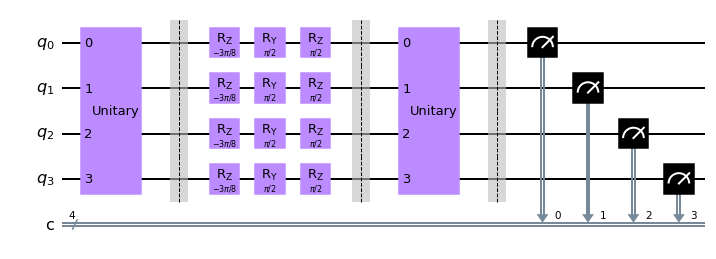

In [25]:
minority_game.set_protocol("EWL", backend = 'simulator')
P1_strategy = ['Rz(-3*pi/8)', 'Ry(pi/2)', 'Rz(pi/2)']
P2_strategy = ['Rz(-3*pi/8)', 'Ry(pi/2)', 'Rz(pi/2)']
P3_strategy = ['Rz(-3*pi/8)', 'Ry(pi/2)', 'Rz(pi/2)']
P4_strategy = ['Rz(-3*pi/8)', 'Ry(pi/2)', 'Rz(pi/2)']
combined_strategies = [P1_strategy, P2_strategy, P3_strategy, P4_strategy]
outcomes, results = minority_game.play_game(combined_strategies, n_times=1000)
minority_game._quantum_game.draw_circuit()

In [26]:
minority_game.show_results()

,Outcome,Payoffs,Winners,num_times
0,1000,"[1.0, 0.0, 0.0, 0.0]",Player 1,119
1,0100,"[0.0, 1.0, 0.0, 0.0]",Player 2,124
2,0010,"[0.0, 0.0, 1.0, 0.0]",Player 3,137
3,1110,"[0.0, 0.0, 0.0, 1.0]",Player 4,132
4,0001,"[0.0, 0.0, 0.0, 1.0]",Player 4,124
5,1101,"[0.0, 0.0, 1.0, 0.0]",Player 3,115
6,1011,"[0.0, 1.0, 0.0, 0.0]",Player 2,121
7,0111,"[1.0, 0.0, 0.0, 0.0]",Player 1,128


Notice that the $J$ gate has now become a 4-qubit gate with the form $$J = \frac{1}{\sqrt{2}} (I^{\otimes 4} + iX^{\otimes 4})$$
Now let us look at the results after playing this game 1000 times.

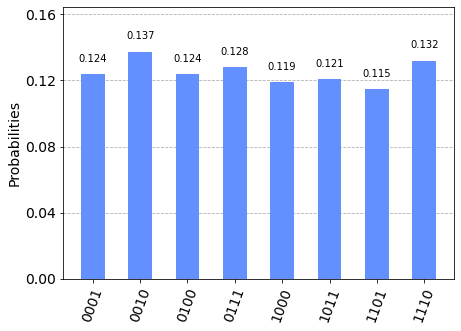

In [27]:
plot_histogram(outcomes)

This result is rather remarkable since it shows that every player has a 1/4 chance of winning despite using only pure strategies! This is unachievable in the classical version of the game even when using mixed strategies. And what is even more intriguing is that in the 3-player version of this game 1) there are no pure strategy Nash equilibria and 2) the players each have a 1/4 chance of winning when in a mixed strategy Nash equilibrium, which is also true for the Nash equilibrium solution for the classical version of the game. So basically, we can't do any better in the 3-player version of the game by making it quantum, but we _can_ in the 4-player version of the game. Why should this be the case? And in what cases of games can we do better in the quantum version compared to the classical ones? The answer to these questions that no one exactly knows yet... welcome to the wonderful and weird world of quantum game theory!

## What next?
Sadly (or maybe finally!) this tutorial has come to an end. But of course, this notebook only scratches the very surface of quantum game theory. Thank you for taking the time to go through this tutorial and we hope you enjoyed it, and maybe even learnt a little something :)

If you are interested in exploring the field of quantum game theory further, but are maybe wondering where to start, we have a few suggestions as to what you could do going forward

### 1. Explore and help build the Quantum Game Theory package
Although we have showcased the Quantum Game Theory package in this tutorial, the code is still very much in progress and there are a many more improvements that could be made to it. Some ideas include
* integrate using mixed strategies into the package (currently the randomization has to be done before inputting the strategies into the Game object)
* Implement the use of arbitrary rotation and/or unitary gates as strategies (currently only certain fixed gates can be used as strategies)
* Implement the EWL protocol with varying degrees of initial entanglement

And of course whatever you think would be an interesting addition to the package! We are always happy to hear new ideas and collaborate so please feel free to reach out to us :)

### 2. Play around with the Quantum Game Theory package and start finding interesting results
We have only shown the very basics of quantum game theory, and there is so much left to explore, ranging from different protocols (try using the ['MW' protocol](https://www.sciencedirect.com/science/article/abs/pii/S0375960100004412?via%3Dihub) in our package!), to multiplayer and multidecision games, finding applications in optimization problems etc. A good place to start looking for inspiration might be the [review by Khan et al](https://link.springer.com/article/10.1007/s11128-018-2082-8) on quanutm game theory. We hope that as we add more features to the Quantum Game Theory package that people will be able to use it as tool to study this fascinating field. Play on playas!

## References
[1] “Chapter 1: Decision-Theoretic Foundations.” [_Game Theory: Analysis of Conflict_](https://www.jstor.org/stable/j.ctvjsf522), by Roger B. Myerson, Harvard University Press, 1997.

[2] “Chapter 2: Nash Equilibrium.” [_A Course in Game Theory_](http://ebour.com.ar/pdfs/A%20Course%20in%20Game%20Theory.pdf), by Martin J. Osborne and Ariel Rubinstein, MIT Press, 1994.

[3] Meyer, David A. “Quantum Strategies.” _Physical Review Letters_ , vol. 82, no. 5, 1999, pp. 1052–1055., doi:10.1103/physrevlett.82.1052.

[4] Eisert, Jens, et al. “Quantum Games and Quantum Strategies.” _Physical Review Letters_ , vol. 83, no. 15, 1999, pp. 3077–3080., doi:10.1103/physrevlett.83.3077.

[5] Benjamin, Simon C., and Patrick M. Hayden. “Multiplayer Quantum Games.” _Physical Review A_ , vol. 64, no. 3, 2001, doi:10.1103/physreva.64.030301.

[6] Benjamin, Simon C., and Patrick M. Hayden. “Comment on ‘Quantum Games and Quantum Strategies''.” _Physical Review Letters_ , vol. 87, no. 6, 2001, doi:10.1103/physrevlett.87.069801.